In [24]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
# Aplicação do HDBSCAN
import umap
from sklearn.metrics import silhouette_score
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import HDBSCAN
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [25]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
print("Contagem dos ECGs:", len(dados))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()
print("Contagem das interferencias dos ECGs:", len(interferencias_ids))

dadosFiltrados = dados[~dados['exam_id'].isin(interferencias_ids)]
print("Contagem dos ECGs sem interferencias:", len(dadosFiltrados))

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) & ((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 13] == True) ]
ecg_ST_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == True) & (dados.iloc[:, 9] == False)]
ecg_SB_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == True) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)]
ecg_AF_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == True)]
ecg_1dAVb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == True) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)]
ecg_LBBB_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == False) & (dados.iloc[:, 6] == True) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)  ]
ecg_RBBB_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &((dados.iloc[:, 14] == "exams_part17.hdf5") | (dados.iloc[:, 14] == "exams_part16.hdf5") ) & (dados.iloc[:, 4] == False) & (dados.iloc[:, 5] == True) & (dados.iloc[:, 6] == False) & (dados.iloc[:, 7] == False) & (dados.iloc[:, 8] == False) & (dados.iloc[:, 9] == False)  ]

print("Número de normais:", len(ecg_normal_linhas))
print("Número de ST:", len(ecg_ST_linhas))
print("Número de SB:", len(ecg_SB_linhas))
print("Número de AF:", len(ecg_AF_linhas))
print("Número de 1DAVB:", len(ecg_1dAVb_linhas))
print("Número de LBBB:", len(ecg_LBBB_linhas))
print("Número de RBBB:", len(ecg_RBBB_linhas))

ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
ecg_ST_id = dados.iloc[ecg_ST_linhas, 0].tolist()
ecg_SB_id = dados.iloc[ecg_SB_linhas, 0].tolist()
ecg_AF_id = dados.iloc[ecg_AF_linhas, 0].tolist()
ecg_1dAVb_id = dados.iloc[ecg_1dAVb_linhas, 0].tolist()
ecg_LBBB_id = dados.iloc[ecg_LBBB_linhas, 0].tolist()
ecg_RBBB_id = dados.iloc[ecg_RBBB_linhas, 0].tolist()

ecg_normal = ecg_normal_id[:10000]
ecg_ST = ecg_ST_id[:300]
ecg_SB = ecg_SB_id[:300]
ecg_AF = ecg_AF_id[:300]
ecg_1dAVb = ecg_1dAVb_id[:300]
ecg_LBBB = ecg_LBBB_id[:300]
ecg_RBBB = ecg_RBBB_id[:300]

ids_ecgs= ecg_normal + ecg_ST + ecg_SB + ecg_AF + ecg_1dAVb
#ids_ecgs_treino = ecg_normal_id[10001:11001] + ecg_ST_id[501:551]

Contagem dos ECGs: 345779
Contagem das interferencias dos ECGs: 23741
Contagem dos ECGs sem interferencias: 322038
Número de normais: 11606
Número de ST: 550
Número de SB: 309
Número de AF: 488
Número de 1DAVB: 362
Número de LBBB: 329
Número de RBBB: 504


In [26]:
#X
def get_ecg_data(file_path, exam_id):
    with h5py.File(file_path, 'r') as f:
        # Obter os IDs dos exames
        exam_ids = np.array(f['exam_id'])

        # Encontrar o índice correspondente ao exam_id de interesse
        exam_index = np.where(exam_ids == exam_id)[0]

        if len(exam_index) == 0:
            raise ValueError("Exam ID não encontrado.")
        else:
            exam_index = exam_index[0]
            # Acessar os tracings de ECG correspondentes ao exam_index
            exam_tracings = f['tracings'][exam_index]
            return exam_tracings
        
# Caminho para o arquivo HDF5
path_to_file = '../Database/filtered_exams_16_17.hdf5'  # Substitua pelo caminho real do arquivo

exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

# Lista para armazenar todos os tracings de ECG
all_tracings = []

# Obter os tracings de ECG para cada exam_id e armazenar na lista
for exam_id in exam_ids_to_cluster:
    tracings = get_ecg_data(path_to_file, exam_id)
    aa = np.array(tracings.T)
    all_tracings.append(aa)

# X será um array com um único array dentro, contendo todos os números do tracings.T
X = np.array(all_tracings)
 
# Usando squeeze
X = np.squeeze(X[:, 1, :])

In [27]:
#CARREGAR MODELO

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, ELU, Input
from tensorflow.keras.models import Model

# Define the encoder
def encoder_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=40, kernel_size=16, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1D(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    encoded = Conv1D(filters=1, kernel_size=16, strides=1, padding='same')(x)

    return Model(inputs, encoded, name="encoder")

# Define the decoder
def decoder_model(encoded_shape):
    inputs = Input(shape=encoded_shape)
    x = Conv1DTranspose(filters=40, kernel_size=16, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ELU()(x)

    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    
    x = Conv1DTranspose(filters=20, kernel_size=16, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)

    decoded = Conv1DTranspose(filters=1, kernel_size=16, strides=2, padding='same')(x)

    return Model(inputs, decoded, name="decoder")

# Define the full autoencoder
def autoencoder_model(input_shape):
    encoder = encoder_model(input_shape)
    decoder = decoder_model(encoder.output_shape[1:])
    
    inputs = Input(shape=input_shape)
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    
    autoencoder = Model(inputs, decoded, name="autoencoder")
    
    return autoencoder

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 57s 169ms/step - loss: 0.0463 - val_loss: 0.0187
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 48s 171ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 46s 163ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 45s 159ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 52s 185ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 36s 130ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 11/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/50
280/280

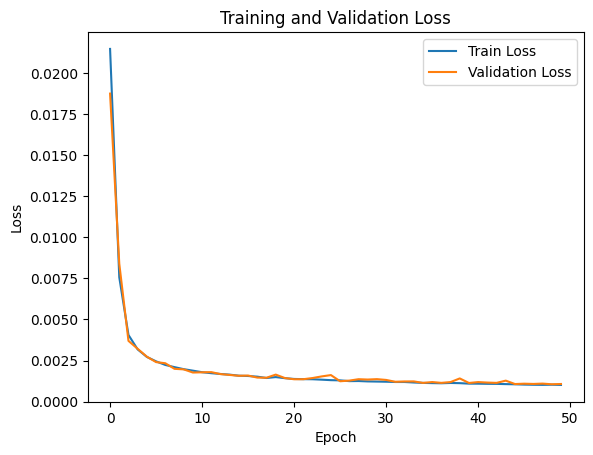

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


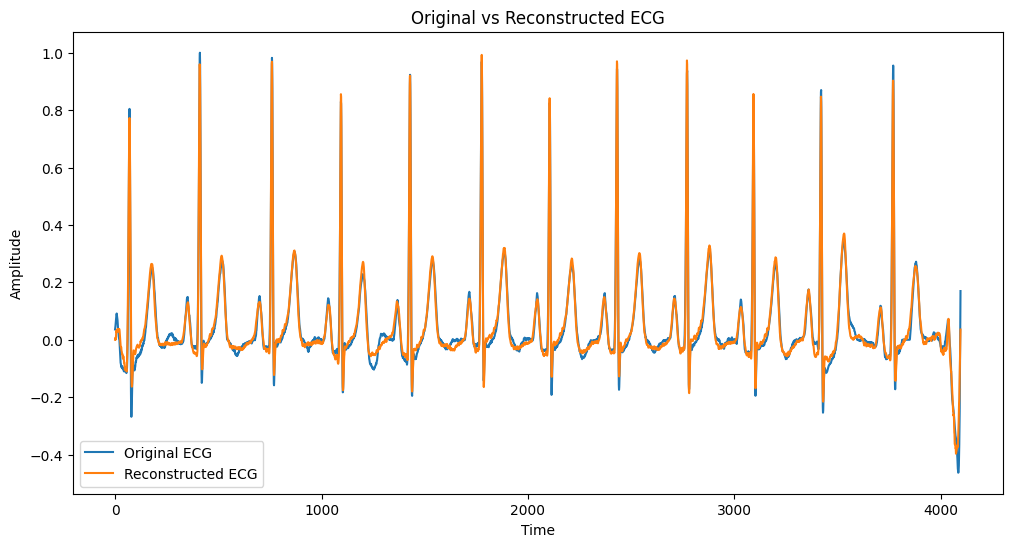

In [28]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
X = X / np.max(np.abs(X), axis=1, keepdims=True)

# Redimensionar os dados para o formato esperado pelo modelo (10500, 4096, 1)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Definir o autoencoder
autoencoder = autoencoder_model((4096, 1))
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

# Plotar a perda de treino e validação
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test[idx]

# Reconstruir o ECG usando o autoencoder
reconstructed_ecg = autoencoder.predict(np.expand_dims(original_ecg, axis=0))

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()

# Salvar o modelo treinado no formato Keras
autoencoder.save('luisa_autoencoder_model_18.keras')

# Salvar o modelo treinado
autoencoder.save('luisa_autoencoder_model_18.h5')

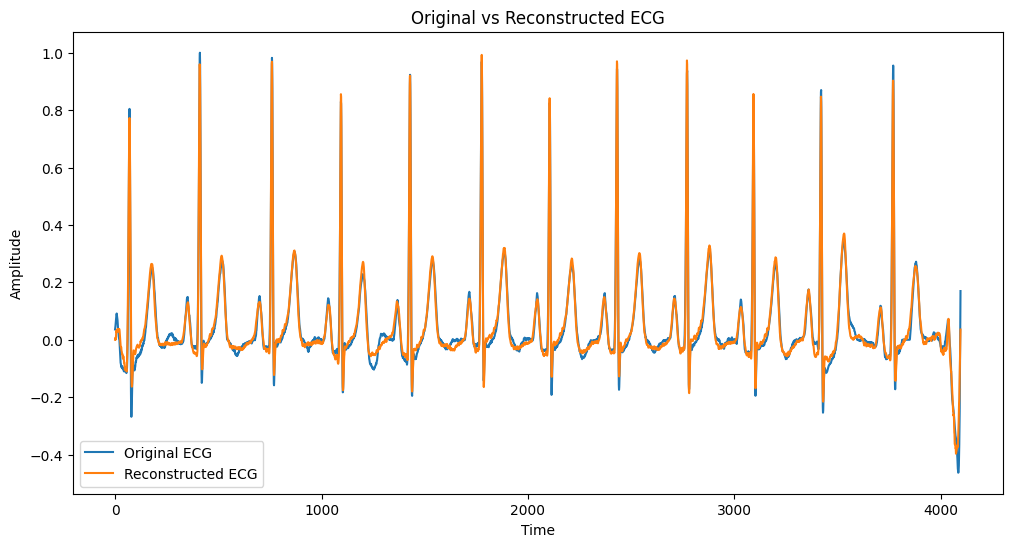

In [29]:
# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()